# Dutch Corpora

In [1]:
# make sure installation has succeeded
import tempo_embeddings

In [2]:
%load_ext autoreload

In [3]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Database

In [4]:
%autoreload now

from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

In [5]:
from tempo_embeddings.embeddings.vector_database import ChromaDatabaseManager

MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"

db = ChromaDatabaseManager(db_path="testing_db", embedder_name=MODEL_NAME, batch_size=24)
db.connect()

duurzam_collection = db.get_existing_collection("anp_duurzam")
anp_duurzam = db.get_corpus(duurzam_collection, include_embeddings=True)

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Retrieved existing collection 'anp_duurzam'


In [6]:
for p in anp_duurzam.passages[:20]:
    print(len(p), p)

corpus = anp_duurzam
corpus.embeddings = db.compress_embeddings(corpus)

if corpus.embeddings is not None:
    print(corpus.embeddings.shape)

200 Passage('Het is met minister Blok gelukt om onder andere met de hypotheekverstrekkers een fonds te ontwikkelen om de mensen die de financiering niet rond kunnen krijgen, op een aparte manier mee te laten doen.', {'': '253', 'RecId': 'h-tk-20162017-42-4', 'chamber': 'TweedeKamer', 'date': '2017-01-19', 'highlighting': 'None', 'speakers': 'Mevrouw Van Veldhoven ( D66 ):|De voorzitter :|De voorzitter :|De voorzitter :|De voorzitter :|De heer Smaling ( SP ):|De voorzitter :|De heer Smaling ( SP ):|De voorzitter :|De heer Smaling ( SP ):|De heer Remco Dijkstra ( VVD ):|De heer Smaling ( SP ):|De heer Remco Dijkstra ( VVD ):|De heer Smaling ( SP ):|De heer Remco Dijkstra ( VVD ):|De heer Albert de Vries ( PvdA ):|De voorzitter :|De heer Remco Dijkstra ( VVD ):|De heer Albert de Vries ( PvdA ):|De heer Remco Dijkstra ( VVD ):|De heer Albert de Vries ( PvdA ):|Staatssecretaris Dijksma :|De voorzitter :|Staatssecretaris Dijksma :|De voorzitter :|Staatssecretaris Dijksma :|De voorzitter :|Me

Epochs completed: 100%| ██████████ 500/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Feb 16 16:12:17 2024 Finished embedding
(102, 2)


## Read Stopwords

In [7]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

zsh:1: command not found: wget


In [8]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster

In [9]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"
FILTER_TERMS = ["duurzaam"] 
clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(0, [0, 1, 2, 5, 19, 31, 32, 36, 45, 49]), Subcorpus(1, [3, 4, 6, 7, 9, 10, 11, 12, 14, 15]), Subcorpus(-1, [8, 13, 17, 18, 26, 27, 34, 35, 43, 53])]


In [10]:
for cluster in clusters:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    print(cluster)

Subcorpus('hypotheekrente; gedaalde; sterk; leningen; red', [0, 1, 2, 5, 19, 31, 32, 36, 45, 49])
Subcorpus('waar; alle; wettelijke; gezegd; eigen', [3, 4, 6, 7, 9, 10, 11, 12, 14, 15])
Subcorpus('Outliers', [8, 13, 17, 18, 26, 27, 34, 35, 43, 53])


/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
with open("clusters.txt", "wt") as f:
    for cluster in clusters:
        print(
            ", ".join(
                cluster.top_words(
                    exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5
                )
            ),
            file=f,
        )

# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

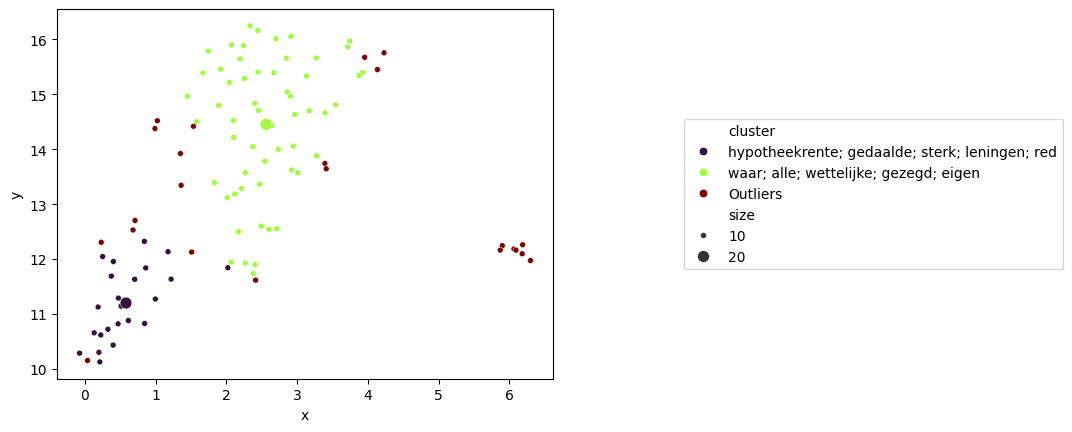

In [12]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [13]:
import os
from bokeh.io import output_notebook
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"

show(visualizer.create_document)

Loading BokehJS ...